In [1]:
import numpy as np
import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard.writer import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# 一个完全空的类
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # 这里定义类的属性

        # 首先将参数存储为属性，以供以后使用
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        # 这些属性将在内部计算
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # 为模型、损失函数和优化器创建train_step函数
        # 注意：哪里没有参数，它直接使用类属性
        self.train_step = self._make_train_step()
        # 为模型和损失函数创建val_step函数
        self.val_step = self._make_val_step()

    def to(self, device):
        # 此方法允许用户指定不同的设备
        # 它设置相应的属性（稍后在小批量中使用)并将模型发送到设备
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # 此方法允许用户定义使用哪个train_loader(和val_loader,可选)
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # 此方法允许用户创建一个SummeryWriter以与TensorBoard交互
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')

    def _make_train_step(self):
        # 这个方法不需要ARGS
        # 可以参考属性:self.model, self.loss_fn和self.optimizer

        # 构建在训练循环中执行一个步骤的函数
        def perform_train_step(x, y):
            # 设置模型为训练模式
            self.model.train()

            # 第1步：计算模型的预测输出--前向传递
            yhat = self.model(x)
            # 第2步：计算损失
            loss = self.loss_fn(yhat, y)
            # 第3步：计算参数b和w的梯度
            loss.backward()

            # 第4步：使用梯度和学习率更新参数
            self.optimizer.step()
            self.optimizer.zero_grad()

            return loss.item()

        return perform_train_step

    def _make_val_step(self):
        # 构建在验证循环中执行步骤的函数
        def perform_val_step(x, y):
            # 设置模型为评估模式
            self.model.eval()

            # 第1步：计算模型的预测输出--前向传递
            yhat = self.model(x)
            # 第2步：计算损失
            loss = self.loss_fn(yhat, y)

            return loss.item()
            
        return perform_val_step

In [3]:
def _mini_batch(self, validation=False):
    # 小批量可以与两个加载器一起使用
    # 参数validation定义了将使用哪个加载器
    # 和相应地将要被使用的步骤函数
    if validation:
        data_loader = self.val_loader
        step = self.val_step
    else:
        data_loader = self.train_loader
        step = self.train_step
    
    if data_loader is None:
        return None

    # 设置好数据加载器和步骤函数
    # 这就是我们之前的小批量循环
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)

    return loss

setattr(StepByStep, '_mini_batch', _mini_batch)

In [4]:
def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    np.random.seed(seed)

setattr(StepByStep, "set_seed", set_seed)

In [5]:
def train(self, n_epochs, seed=42):
    # 确保训练过程的可重复性
    self.set_seed(seed)

    for epoch in range(n_epochs):
        # 通过更新相应的属性来跟踪周期数
        self.total_epochs += 1

        # 内循环
        # 使用小批量执行训练
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # 评估 -- 在评估期间不再需要梯度
        with torch.no_grad():
            # 使用小批量执行评估
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        # 如果设置了SummaryWriter....
        if self.writer is not None:
            scalars = {'training': loss}
            if self.val_losses is not None:
                scalars.update({'validation': val_loss})

            self.writer.add_scalars(
                main_tag="loss",
                tag_scalar_dict=scalars,
                global_step=epoch
            )
    if self.writer is not None:
        self.writer.flush()

setattr(StepByStep, "train", train)

In [6]:
def save_checkpoint(self, filename):
    # 构建包含所有元素的字典以恢复训练
    checkpoint = {
        'epoch': self.total_epochs,
        'model_state_dict': self.model.state_dict(),
        'optimizer_state_dict':self.optimizer.state_dict(),
        'loss': self.losses,
        'val_loss': self.val_losses
    }

    torch.save(checkpoint, filename)

setattr(StepByStep, 'save_checkpoint', save_checkpoint)

In [7]:
def load_checkpoint(self, filename):
    # 加载字典
    checkpoint = torch.load(filename)

    # 恢复模型和优化器的状态
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    self.total_epochs = checkpoint['epoch']
    self.losses = checkpoint['loss']
    self.val_losses = checkpoint['val_loss']

    self.model.train() # always use TRAIN for resuming training

setattr(StepByStep, 'load_checkpoint', load_checkpoint)

In [19]:
def predict(self, x):
    # 设置为预测的评估模式
    self.model.eval()
    # 获取Numpy输入并使其成为一个浮点张量
    x_tensor = torch.as_tensor(x).float().to(self.device)
    # 将输入发送到设备并使用模型进行预测
    y_hat_tensor = self.model(x_tensor)
    # 将其设置会训练模式
    self.model.train()
    # 分离，将其带到CPU，并返回到Numpy
    return y_hat_tensor.detach().cpu().numpy()

setattr(StepByStep, 'predict', predict)

In [9]:
def plot_losses(self):
    fig = plt.figure(figsize=(10, 4))
    plt.plot(self.losses, label='Training Losses', c='b')
    if self.val_loader:
        plt.plot(self.val_losses, label='Validation Loss', c='r')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    return fig

setattr(StepByStep, 'plot_losses', plot_losses)

In [10]:
def add_graph(self):
    if self.train_loader and self.writer:
        # 获取单个小批量，以便可以使用add_graph
        x_dummy, y_dummy = next(iter(self.train_loader))
        self.writer.add_graph(self.model, x_dummy.to(self.device))

setattr(StepByStep, 'add_graph', add_graph)

In [11]:
%%writefile model_configuration/v4.py

# 设置学习率
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1, 1))

optimizer = optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss(reduction='mean')

Overwriting model_configuration/v4.py


In [12]:
%run -i data_generation/simple_linear_regression.py
%run -i data_preparetion/v2.py
%run -i model_configuration/v4.py

In [13]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


In [14]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

print(sbs.model == model)
print(sbs.model)

True
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


In [15]:
sbs.train(n_epochs=200)
print(model.state_dict())
print(sbs.total_epochs)

OrderedDict([('0.weight', tensor([[1.9416]])), ('0.bias', tensor([1.0235]))])
200


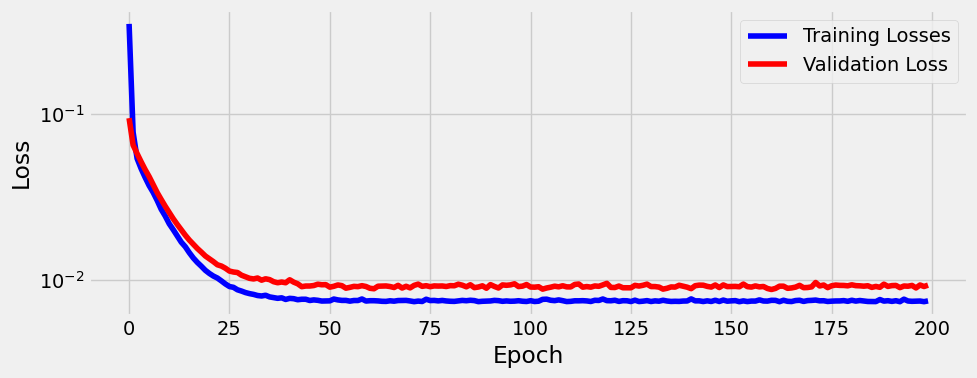

In [16]:
fig = sbs.plot_losses()

In [17]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
new_data

array([[0.5],
       [0.3],
       [0.7]])

In [20]:
predictions = sbs.predict(new_data)
predictions

array([[1.9942763],
       [1.605955 ],
       [2.3825974]], dtype=float32)

In [21]:
sbs.save_checkpoint('model_checkpoint.pth')

In [22]:
%run -i model_configuration/v4.py

<Figure size 640x480 with 0 Axes>

In [23]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


In [24]:
new_sbs = StepByStep(model, loss_fn=loss_fn, optimizer=optimizer)
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]])), ('0.bias', tensor([1.0235]))])


In [25]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)

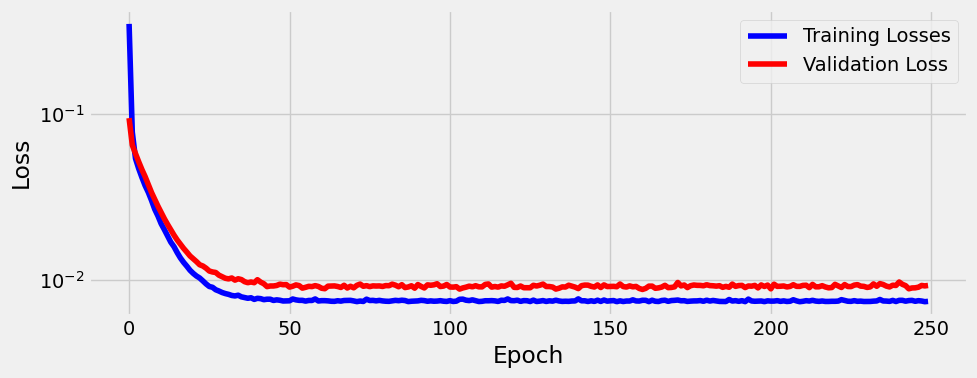

In [26]:
fig = new_sbs.plot_losses()

In [27]:
print(sbs.model.state_dict())

OrderedDict([('0.weight', tensor([[1.9416]])), ('0.bias', tensor([1.0235]))])
